In [1]:
import matplotlib.pyplot as plt
import numpy as np
# ^^^ pyforest auto-imports - don't write above this line
# from pulp import *
from scipy import interpolate
from scipy.optimize import fmin, fminbound, minimize, BFGS

In [2]:
class Vehicle:
    def __init__(self, ):
        self.pos=[] # x, y [m]
        self.size=[] # length, width [m]
        self.ori=[] # [rad]
        self.vel=[] # [m/s]

In [3]:
def vehicle_plot(pos, size, ori):
    if 0:
        points = [
            [pos[0] - size[0]/2, pos[0] + size[0]/2, pos[0] + size[0]/2, pos[0] - size[0]/2, pos[0] - size[0]/2],
            [pos[1] - size[1]/2, pos[1] - size[1]/2, pos[1] + size[1]/2, pos[1] + size[1]/2, pos[1] - size[1]/2]
        ]
    else:
        points = [[],[]]
        x = [- size[0]/2, size[0]/2, size[0]/2, - size[0]/2, - size[0]/2]
        y = [- size[1]/2, - size[1]/2, size[1]/2, size[1]/2, - size[1]/2]
        A = [[np.cos(ori), -np.sin(ori)],[np.sin(ori), np.cos(ori)]]
        for i in range(len(x)):
            buf = np.dot(A,np.array([x[i],y[i]]))
            points[0].append(buf[0] + pos[0])
            points[1].append(buf[1] + pos[1])
    plt.plot(points[0], points[1])

In [4]:
# 駐車車両
parked_vehicle = Vehicle()
parked_vehicle.pos = [20, 1.5]
parked_vehicle.size = [4, 2]
parked_vehicle.ori = 0
parked_vehicle.ori = 0

# 自社
ego_vehicle = Vehicle()
ego_vehicle.pos = [0,0]
ego_vehicle.size = [4,2]
ego_vehicle.ori = 0
ego_vehicle.vel = 10/3.6

 # 車線
width_lane = 4
line_left = [[0,40],[width_lane/2, width_lane/2]]
line_center = [[0,40], [0,0]]
line_right = [[0,40],[-width_lane/2, -width_lane/2]]

Text(0, 0.5, 'Y[m]')

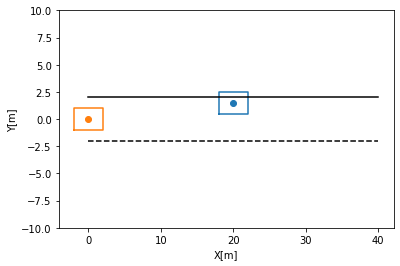

In [5]:
# 描画
plt.scatter(parked_vehicle.pos[0], parked_vehicle.pos[1])
vehicle_plot(parked_vehicle.pos, parked_vehicle.size, parked_vehicle.ori)
plt.scatter(ego_vehicle.pos[0], ego_vehicle.pos[1])
vehicle_plot(ego_vehicle.pos, ego_vehicle.size, ego_vehicle.ori)

plt.plot(line_left[0], line_left[1], 'k')
plt.plot(line_right[0], line_right[1], '--k')

plt.ylim([-10,10])
plt.xlabel('X[m]')
plt.ylabel('Y[m]')

In [14]:
#interpld
# ValueError: The number of derivatives at boundaries does not match: expected 1, got 0+0
# 2点だとエラー
def spline1(x,y,point):
    kind_option = 'cubic' if len(x) > 3 else 'quadratic'
    f = interpolate.interp1d(x, y,kind=kind_option) #kindの値は一次ならslinear、二次ならquadraticといった感じに
    X = np.linspace(x[0],x[-1],num=point,endpoint=True)
    Y = f(X)
    return X,Y

#Akima1DInterpolator
def spline2(x,y,point):
    f = interpolate.Akima1DInterpolator(x, y)
    X = np.linspace(x[0],x[-1],num=point,endpoint=True)
    Y = f(X)
    return X,Y

#splprep
def spline3(x,y,point,deg):
    tck,u = interpolate.splprep([x,y],k=deg,s=0) 
    u = np.linspace(0,1,num=point,endpoint=True) 
    spline = interpolate.splev(u,tck)
    return spline[0],spline[1]

In [15]:
# 経路評価
def evaluation_path(X):
    
    points = [
        [ego_vehicle.pos[0], parked_vehicle.pos[0] + X[0], line_center[0][1]], 
        [ego_vehicle.pos[1], parked_vehicle.pos[1] + X[1], line_center[1][1]]
    ]
    
    if 0:
        path_coef = np.polyfit(points[0], points[1], 6)
        path_x= np.linspace(ego_vehicle.pos[0], line_left[0][1], 20)
        path_y = np.poly1d(path_coef)(path_x)
    else:
        path_x, path_y = spline1(points[0], points[1], 20)
        
    
    eval_val = 0 
    
    # (１)死角
    eval_val += 1 * calculation_dead_area(path_x, path_y)
    
    # (２)はみ出し
    eval_val += 1 * calculation_out_of_road(path_x, path_y)
    
    # (３)衝突
    eval_val += 1 * calculation_collision(path_x, path_y)
    
    # (４)道路中央を走行
    eval_val += 100 * calculation_center_of_road(path_x, path_y)
    
    # (５)ジャーク（yの二回微分）
    eval_val += 1 * calculation_lat_jark(path_x, path_y)    
    
    # (６)ハンドル角速度（曲率変化量） 
    
    return eval_val

In [16]:
# 死角の計算
def calculation_dead_area(path_x, path_y):
    fr = [parked_vehicle.pos[0] + parked_vehicle.size[0]/2, parked_vehicle.pos[1] - parked_vehicle.size[1]/2]
    fl = [parked_vehicle.pos[0] + parked_vehicle.size[0]/2, parked_vehicle.pos[1] + parked_vehicle.size[1]/2]
    
    dead_area = 0
    pp = [0, 0]
    
    if 0:
        plt.scatter(parked_vehicle.pos[0], parked_vehicle.pos[1])
        vehicle_plot(parked_vehicle.pos, parked_vehicle.size, parked_vehicle.ori)
        plt.scatter(ego_vehicle.pos[0], ego_vehicle.pos[1])
        vehicle_plot(ego_vehicle.pos, ego_vehicle.size, ego_vehicle.ori)

        plt.plot(line_left[0], line_left[1], 'k')
        plt.plot(line_right[0], line_right[1], '--k')

        plt.ylim([-10,10])
        plt.xlim([0,40])
        plt.xlabel('X[m]')
        plt.ylabel('Y[m]')
    
    for i in range(len(path_x)):
        if 0:
            a = ( (fr[0] - path_x[i]) / (fr[1] - path_y[i]) ) * parked_vehicle.size[1]
            b = parked_vehicle.size[1] 
            dead_area += a * b * 1/2
        else:
            if (path_x[i] < fr[0]):
                a = (fr[1] - path_y[i]) / (fr[0] - path_x[i])
                b = fr[1] - a * fr[0]
                
                pp[0] = (fl[1] - b)/a
                pp[1] = fl[1]

                if (pp[0] > fl[0]):
                    dead_area += (pp[0] - fl[0])*(fl[1] - fr[1])*1/2
                # plt.plot([pp[0], fl[0], fr[0], pp[0]], [pp[1], fl[1], fr[1], pp[1]])
    
    return dead_area

In [17]:
# はみ出し
def calculation_out_of_road(path_x, path_y):
    return np.sum(path_y<line_right[1][0]) + 1000*np.sum(path_y>0)

In [18]:
# 衝突
def calculation_collision(path_x, path_y):
    d = np.sqrt((parked_vehicle.pos[0] - path_x) ** 2 + (parked_vehicle.pos[1] - path_y) ** 2)
    d_min = np.min(d)
    torelance = 3
    ret = np.sum(1/np.exp(d))
    if d_min < torelance:
        #ret = np.inf
        ret = 100000000*ret
        
    return ret

In [19]:
# 道路中央
def calculation_center_of_road(path_x, path_y):
    return np.sum(np.exp(np.abs(path_y - line_center[1][0])))

In [20]:
# 横ジャーク
def calculation_lat_jark(path_x, path_y):
    return np.sum(np.diff(path_y, n=2))

In [21]:
# dx, dy = fmin(evaluation_path, [0, 0])
# dx, dy = fminbound(evaluation_path, [-10, -3], [0, 0])

p_init = [--10,-3]

dxmin = -20
dxmax = 0
dymin = -6
dymax = 0

bounds = [[dxmin,dxmax], [dymin,dymax]]
res = minimize(evaluation_path, 
               x0=p_init, 
               bounds=bounds, 
               tol = 1e-10,
               method="trust-constr",  # 制約付き信頼領域法
               # jac="2-point",          # 勾配関数
               hess=BFGS(),            # ヘシアンの推定方法
               options={"maxiter": 1000, # 最大反復数
                         "verbose":2} # 最適化の過程を出力
              )  
            

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   3   |   0   | +8.7200e+03 | 1.00e+00 | 8.16e+03 | 1.00e+01 |
|   2   |   6   |   1   | +8.7200e+03 | 1.00e-01 | 8.16e+03 | 1.00e+01 |
|   3   |   9   |   3   | +8.7168e+03 | 5.60e-01 | 8.16e+03 | 1.00e+01 |
|   4   |  12   |   5   | +8.6895e+03 | 3.92e+00 | 8.10e+03 | 9.99e+00 |
|   5   |  15   |   7   | +8.6895e+03 | 3.92e-01 | 8.10e+03 | 9.99e+00 |
|   6   |  18   |   9   | +8.3021e+03 | 2.74e+00 | 7.40e+03 | 9.88e+00 |
|   7   |  21   |  11   | +5.5128e+03 | 1.15e+01 | 4.16e+03 | 8.62e+00 |
|   8   |  24   |  12   | +5.5128e+03 | 3.61e+00 | 4.16e+03 | 8.62e+00 |
|   9   |  27   |  14   | +5.5128e+03 | 1.03e+00 | 4.16e+03 | 8.62e+00 |
|  10   |  30   |  16   | +5.5128e+03 | 1.77e-01 | 4.16e+03 | 8.62e+00 |
|  11   |  33   |  17   | +5.3466e+03 | 1.01e+00 | 3.97e+03 | 8.48e+00 |
|  12   |  36   |  19   | +5.3466e+03 | 1.44e-01 | 

|  118  |  354  |  129  | +5.2512e+03 | 9.37e-07 | 3.00e+03 | 0.00e+00 |
|  119  |  357  |  130  | +5.2512e+03 | 9.37e-07 | 3.00e+03 | 0.00e+00 |
|  120  |  360  |  131  | +5.2512e+03 | 9.37e-07 | 3.00e+03 | 0.00e+00 |
|  121  |  363  |  132  | +5.2512e+03 | 9.37e-07 | 3.00e+03 | 0.00e+00 |
|  122  |  366  |  133  | +5.2512e+03 | 6.56e-06 | 3.00e+03 | 0.00e+00 |
|  123  |  369  |  134  | +5.2512e+03 | 6.56e-07 | 3.00e+03 | 0.00e+00 |
|  124  |  372  |  135  | +5.2512e+03 | 6.56e-07 | 3.00e+03 | 0.00e+00 |
|  125  |  375  |  136  | +5.2512e+03 | 6.56e-07 | 3.00e+03 | 0.00e+00 |
|  126  |  378  |  137  | +5.2512e+03 | 4.59e-06 | 3.00e+03 | 0.00e+00 |
|  127  |  381  |  138  | +5.2512e+03 | 4.59e-07 | 3.00e+03 | 0.00e+00 |
|  128  |  384  |  139  | +5.2512e+03 | 4.59e-07 | 3.00e+03 | 0.00e+00 |
|  129  |  387  |  140  | +5.2512e+03 | 4.59e-07 | 3.00e+03 | 0.00e+00 |
|  130  |  390  |  141  | +5.2512e+03 | 4.59e-07 | 3.00e+03 | 0.00e+00 |
|  131  |  393  |  142  | +5.2512e+03 | 4.59e-07 | 

/usr/local/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


|  137  |  411  |  148  | +5.2512e+03 | 3.21e-06 | 3.00e+03 | 0.00e+00 |
|  138  |  414  |  149  | +5.2512e+03 | 3.21e-07 | 3.00e+03 | 0.00e+00 |
|  139  |  417  |  150  | +5.2512e+03 | 3.21e-07 | 3.00e+03 | 0.00e+00 |
|  140  |  420  |  151  | +5.2512e+03 | 3.21e-07 | 3.00e+03 | 0.00e+00 |
|  141  |  423  |  152  | +5.2512e+03 | 3.21e-07 | 3.00e+03 | 0.00e+00 |
|  142  |  426  |  153  | +5.2512e+03 | 3.21e-07 | 3.00e+03 | 0.00e+00 |
|  143  |  429  |  154  | +5.2512e+03 | 3.21e-07 | 3.00e+03 | 0.00e+00 |
|  144  |  432  |  155  | +5.2512e+03 | 2.25e-06 | 3.00e+03 | 0.00e+00 |
|  145  |  435  |  156  | +5.2512e+03 | 2.25e-07 | 3.00e+03 | 0.00e+00 |
|  146  |  438  |  157  | +5.2512e+03 | 2.25e-07 | 3.00e+03 | 0.00e+00 |
|  147  |  441  |  158  | +5.2512e+03 | 2.25e-07 | 3.00e+03 | 0.00e+00 |
|  148  |  444  |  159  | +5.2512e+03 | 2.25e-07 | 3.00e+03 | 0.00e+00 |
|  149  |  447  |  160  | +5.2512e+03 | 1.57e-06 | 3.00e+03 | 0.00e+00 |
|  150  |  450  |  161  | +5.2512e+03 | 1.57e-07 | 

|  274  |  453  |  275  | +5.2512e+03 | 1.00e-10 | 3.00e+03 | 0.00e+00 |
|  275  |  453  |  276  | +5.2512e+03 | 1.00e-11 | 3.00e+03 | 0.00e+00 |
|  276  |  453  |  276  | +5.2512e+03 | 1.00e+00 | 3.00e+03 | 0.00e+00 |
|  277  |  453  |  277  | +5.2512e+03 | 1.00e-01 | 3.00e+03 | 0.00e+00 |
|  278  |  453  |  278  | +5.2512e+03 | 1.00e-02 | 3.00e+03 | 0.00e+00 |
|  279  |  453  |  279  | +5.2512e+03 | 1.00e-03 | 3.00e+03 | 0.00e+00 |
|  280  |  453  |  280  | +5.2512e+03 | 1.00e-04 | 3.00e+03 | 0.00e+00 |
|  281  |  453  |  281  | +5.2512e+03 | 1.00e-05 | 3.00e+03 | 0.00e+00 |
|  282  |  453  |  282  | +5.2512e+03 | 1.00e-06 | 3.00e+03 | 0.00e+00 |
|  283  |  453  |  283  | +5.2512e+03 | 1.00e-07 | 3.00e+03 | 0.00e+00 |
|  284  |  453  |  284  | +5.2512e+03 | 1.00e-08 | 3.00e+03 | 0.00e+00 |
|  285  |  453  |  285  | +5.2512e+03 | 1.00e-09 | 3.00e+03 | 0.00e+00 |
|  286  |  453  |  286  | +5.2512e+03 | 1.00e-10 | 3.00e+03 | 0.00e+00 |
|  287  |  453  |  287  | +5.2512e+03 | 1.00e-11 | 

In [22]:
res

 barrier_parameter: 8.192000000000006e-11
 barrier_tolerance: 8.192000000000006e-11
          cg_niter: 309
      cg_stop_cond: 4
            constr: [array([-1.39816277e-03, -2.81290270e+00])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 3.4059548377990723
               fun: 5251.159954541838
              grad: array([-3.36914062e-02, -3.67442084e+03])
               jac: [<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([-6.58617092e-08, -2.99993836e+03])
           message: '`xtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 453
              nhev: 0
               nit: 311
             niter: 311
              njev: 0
        optimality: 2999.938355203003
            status: 2
           success: True
         tr_radius: 1.0000000000000006e-11
    

In [33]:
dx, dy = res.x
dx, dy

(-0.001398162765746526, -2.8129027015637154)

Text(0, 0.5, 'Y[m]')

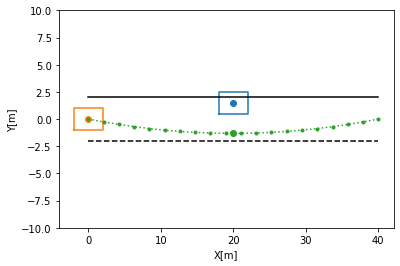

In [34]:
points = [
    [ego_vehicle.pos[0], parked_vehicle.pos[0] + dx, line_center[0][1]], 
    [ego_vehicle.pos[1], parked_vehicle.pos[1] + dy, line_center[1][1]]
]

if 0:
    path_coef = np.polyfit(points[0], points[1], 6)
    path_x= np.linspace(ego_vehicle.pos[0], line_left[0][1], 20)
    path_y = np.poly1d(path_coef)(path_x)
else:
    path_x, path_y = spline1(points[0], points[1], 20)

plt.scatter(parked_vehicle.pos[0], parked_vehicle.pos[1])
vehicle_plot(parked_vehicle.pos, parked_vehicle.size, parked_vehicle.ori)
plt.scatter(ego_vehicle.pos[0], ego_vehicle.pos[1])
vehicle_plot(ego_vehicle.pos, ego_vehicle.size, ego_vehicle.ori)

plt.plot(line_left[0], line_left[1], 'k')
plt.plot(line_right[0], line_right[1], '--k')

plt.scatter(parked_vehicle.pos[0]+dx, parked_vehicle.pos[1]+dy)
plt.plot(path_x, path_y,':.')

plt.ylim([-10,10])
plt.xlabel('X[m]')
plt.ylabel('Y[m]')

In [35]:
calculation_dead_area(path_x, path_y)

267.18708919388934

In [36]:
calculation_collision(path_x, path_y)

0.13561419570396216

In [37]:
calculation_center_of_road(path_x, path_y)

49.833135448088946

In [38]:
calculation_out_of_road(path_x, path_y)

0

In [39]:
dx, dy = -19, -6

Text(0, 0.5, 'Y[m]')

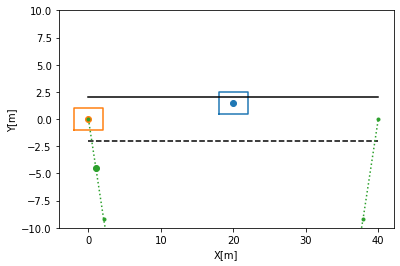

In [40]:
points = [
    [ego_vehicle.pos[0], parked_vehicle.pos[0] + dx, line_center[0][1]], 
    [ego_vehicle.pos[1], parked_vehicle.pos[1] + dy, line_center[1][1]]
]
    
if 0:
    path_coef = np.polyfit(points[0], points[1], 6)
    path_x= np.linspace(ego_vehicle.pos[0], line_left[0][1], 20)
    path_y = np.poly1d(path_coef)(path_x)
else:
    path_x, path_y = spline1(points[0], points[1], 20)

plt.scatter(parked_vehicle.pos[0], parked_vehicle.pos[1])
vehicle_plot(parked_vehicle.pos, parked_vehicle.size, parked_vehicle.ori)
plt.scatter(ego_vehicle.pos[0], ego_vehicle.pos[1])
vehicle_plot(ego_vehicle.pos, ego_vehicle.size, ego_vehicle.ori)

plt.plot(line_left[0], line_left[1], 'k')
plt.plot(line_right[0], line_right[1], '--k')

plt.scatter(parked_vehicle.pos[0]+dx, parked_vehicle.pos[1]+dy)
plt.plot(path_x, path_y,':.')

plt.ylim([-10,10])
plt.xlabel('X[m]')
plt.ylabel('Y[m]')

In [41]:
calculation_dead_area(path_x, path_y)

98.04112010762441

In [42]:
calculation_collision(path_x, path_y)

5.69586609212412e-09

In [43]:
calculation_center_of_road(path_x, path_y)

2.7450818114137578e+20

In [44]:
calculation_out_of_road(path_x, path_y)

18